In [25]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def Q_func_old(s, X):
    Nd, Ns = X.shape
    #assert s >= 2 and s <= (Ns-2) and math.floor(s) == s
    assert s >= 2 and s <= (Ns-2) and np.floor(s) == s
    col_combos = list(it.combinations(range(Ns), s)) # Tuples of possible combinations of s out of Ns column indices

    Z_sum = np.zeros((Nd, Nd))
    S2_sum = np.zeros((Nd, Nd))

    for col_combo in col_combos:
        X1 = X[:, col_combo]
        X2 = X[:, np.delete(range(Ns), col_combo)]
        
        S1 = 1/(s-1)*np.matmul(X1, X1.T)
        S2 = 1/(Ns-s-1)*np.matmul(X2, X2.T)
        S2_sum += S2
        
        # Diagonalize S_i = U_i * D_i * U_i^T
        evals1, U1 = np.linalg.eigh(S1)
        D1 = np.diag(evals1)
        #evals2, U2 = np.linalg.eig(S2)
        #D2 = np.diag(evals2)
        
        # Verify that the matrix diagonalization is correct (up to absolute error of 1e^-10)
        S1_trial = np.matmul(np.matmul(U1, D1), U1.T)
        #S2_trial = np.matmul(np.matmul(U2, D2), U2.T)
        assert np.allclose(S1, S1_trial, 0, 1e-10)
        #assert np.allclose(S2, S2_trial, 0, 1e-10)
        
        # Compute estimator Z = U_1 * diag(U_1^T * S_2 * U_1) * U_1^T
        Z = np.matmul(np.matmul(U1, np.diag(np.diag(np.matmul(np.matmul(U1.T, S2), U1)))), U1.T)
        Z_sum += Z
    
    Z_avg = Z_sum / len(col_combos)
    S2_avg = S2_sum / len(col_combos)
    M = Z_avg - S2_avg
    Q_val = np.trace(np.matmul(M, M.T)) # Frobenius matrix norm
    
    return Q_val, Z_avg

In [27]:
def NERCOME_old(X):
    Nd, Ns = X.shape
    
    # NERCOME requires the data vectors to be mean subtracted
    x_mean = np.sum(X, axis=1)/Ns # Find mean of each row
    x_mean_M = np.tile(x_mean, (Ns, 1)).T # Repeat mean values as columns in a p x n matrix
    Y = X - x_mean_M
    
    s = np.arange(Ns-3)+2
    Q = []
    for i in s:
        Q.append(Q_func_old(i, Y)[0])
    
    s_min = s[np.array(Q).argmin()]
    
    Z = Q_func_old(s_min, Y)[1]
    S = 1/(Ns-1)*np.matmul(Y, Y.T)
    
    return Z, S, s_min

In [90]:
def Q_func_revised(s, X):
    Nd, Ns = X.shape
    
    # This is required for the division by s-1 and Ns-s-1.
    # We also require s to be an integer
    assert s >= 2 and s <= (Ns-2) and np.floor(s) == s
    s = s.astype(int) # convert to type int in case s was an integer floating point number
    
    # Calculate the number of unique combinations of selecting s from Ns columns and compare
    # to the maximum number of averaging that we want to do
    nr_col_combos = np.math.factorial(Ns) // (np.math.factorial(s) * np.math.factorial(Ns-s))
    Nav_max = 1000 # SHOULD THIS DEPEND ON VALUE FOR Nd??
    Nav = np.amin([nr_col_combos, Nav_max]) # Take the mimimum of the two
    
    if Nav < nr_col_combos:
        # Fill a matrix with zeros and populate it with random column indices
        # The rows are arrays of column indices that we are going to average over
        # The columns are the number of averaging that we are going to do
        M = np.zeros((Nav,s))
        for i in range(Nav):
            M[i, :] = np.sort(np.random.choice(Ns, s, replace=False)) # Sort required to filter unique duplicates in np.unique
        # Filter out duplicates and cast values as integer type
        # The probability of getting duplicates is very low
        col_combos = np.unique(M.astype(int), axis=0)
    else:
        # If the number of unique combinations is smaller than the maximum averaging number, then we
        # average of the all the possible combinations
        col_combos = np.array(list(it.combinations(range(Ns), s)))
    
    Z_sum = np.zeros((Nd, Nd))
    S2_sum = np.zeros((Nd, Nd))
    
    # Go through all the column combinations
    for col_combo in col_combos:
        # Create new array by giving only selecting specific columns
        X1 = X[:, col_combo]
        # Create array which consists of all columns not chosen
        X2 = X[:, np.delete(range(Ns), col_combo)]
        
        S1 = 1/(s-1) * X1@X1.T
        S2 = 1/(Ns-s-1) * X2@X2.T
        S2_sum += S2
        
        # Diagonalize S_i = U_i * D_i * U_i^T
        evals1, U1 = np.linalg.eigh(S1)
        D1 = np.diag(evals1)
        
        # Verify that the matrix diagonalization is correct (up to absolute error of 1e^-10)
        S1_trial = U1@D1@U1.T
        assert np.allclose(S1, S1_trial, 0, 1e-10)
        
        # Compute estimator Z = U_1 * diag(U_1^T * S_2 * U_1) * U_1^T
        #Z = np.matmul(np.matmul(U1, np.diag(np.diag(np.matmul(np.matmul(U1.T, S2), U1)))), U1.T)
        Z = U1@np.diag(np.diag(U1.T@S2@U1))@U1.T
        Z_sum += Z
    
    # Find average of estimated matrices
    Z_avg = Z_sum / len(col_combos)
    S2_avg = S2_sum / len(col_combos)
    
    # Calculate Frobenius matrix norm, ie mean squared error
    M = Z_avg - S2_avg
    Q_val = np.trace(M@M.T)
    
    return Q_val, Z_avg

In [91]:
def NERCOME_revised(X):
    Nd, Ns = X.shape
    
    # NERCOME requires the data vectors to be mean subtracted
    x_mean = np.sum(X, axis=1)/Ns # Find mean of each row
    x_mean_M = np.tile(x_mean, (Ns, 1)).T # Repeat mean values as columns in a Nd x Ns matrix
    Y = X - x_mean_M
    
    # Consider following values for s according to paper by Lam in 2016
    s = np.unique(np.rint(np.array([2*np.sqrt(Ns), 0.2*Ns, 0.4*Ns, 0.6*Ns, 0.8*Ns, Ns-2.5*np.sqrt(Ns), Ns-1.5*np.sqrt(Ns)])).astype(int))
    Q = []
    for i in s:
        Q.append(Q_func_revised(i, Y)[0])
    
    # Get value for s corresponding to minimum value for Q
    s_min = s[np.array(Q).argmin()]
    
    # Obtain best estimates for NERCOME covariance matrix and sample covariance matrix
    Z = Q_func_revised(s_min, Y)[1]
    S = 1/(Ns-1) * Y@Y.T
    
    return Z, S, s_min

In [92]:
p = 30
n = 1600
mean = 0
sigmaA = 1
sigmaB = np.sqrt(5)

A = np.random.normal(mean, sigmaA, size=(p//2, n))
B = np.random.normal(mean, sigmaB, size=(p-p//2, n))
X = np.vstack((A, B))

C_true_A = np.full(p//2, sigmaA**2)
C_true_B = np.full(p-p//2, sigmaB**2)
C_true = np.diag(np.concatenate((C_true_A, C_true_B)))

C_nercome_revised, S_revised, s_min_revised = NERCOME_revised(X)
#C_nercome_old, S_old, s_min_old = NERCOME_old(X)

#print(s_min_old)
print(s_min_revised)

960


MSE for revised NERCOME: 1.8062802237214848


Text(0, 0.5, 'Eigenvalues')

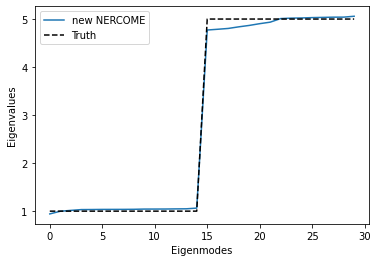

In [93]:
MSE_revised = np.trace((C_nercome_revised-C_true)@(C_nercome_revised-C_true).T)
#MSE_old = np.trace((C_nercome_old-C_true)@(C_nercome_old-C_true).T)

#print(f"MSE for old NERCOME: {MSE_old}")
print(f"MSE for revised NERCOME: {MSE_revised}")

#evals_old = np.linalg.eigvalsh(C_nercome_old)
evals_revised = np.linalg.eigvalsh(C_nercome_revised)
evals_true = np.linalg.eigvalsh(C_true)

#plt.plot(evals_old, label="old NERCOME")
plt.plot(evals_revised, label="new NERCOME")
plt.plot(evals_true, "k--", label="Truth")
plt.legend()
plt.xlabel("Eigenmodes")
plt.ylabel("Eigenvalues")